In [94]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cross_validation import LeaveOneOut
from sklearn.grid_search import (GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier # Used for imputing rare / missing values

# Regressors considered:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge # only model used for final submission


In [195]:
# Kaggle added approximately 311.5 "fake" data points to the test for each real data point. 
# Dividing by this number gives more accurate counts of the "real" data in the test set.
FAKE_DATA_RATIO = 311.5
# Set a Random Seed
SEED = 0

In [46]:
train = pd.read_csv('/Users/Sri/Desktop/Kaggle/TFI Restaurant Sales/train.csv', parse_dates=[1], index_col=0)
test = pd.read_csv('/Users/Sri/Desktop/Kaggle/TFI Restaurant Sales/test.csv', parse_dates=[1], index_col=0)

In [45]:
print(df.shape)
print(test.shape)

(137, 42)
(100000, 41)


In [49]:
train.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
Id,,,,,,,,,,,,,,,,,,,,,
0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4,4,2,2,...,3.0,5,3,4,5,5,4,3,4,5653753
1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4,4,1,2,...,3.0,0,0,0,0,0,0,0,0,6923131
2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2,5,2,3,...,3.0,0,0,0,0,0,0,0,0,2055379
3,2012-02-02,Tokat,Other,IL,6,4.5,6,6,4,4,...,7.5,25,12,10,6,18,12,12,6,2675511
4,2009-05-09,Gaziantep,Other,IL,3,4.0,3,4,2,2,...,3.0,5,1,3,2,3,4,3,3,4316715


In [81]:
# Concatenate train and test together to pre-process and featurize both consistently.
df = pd.concat((test, train), ignore_index=True)
df.describe()

,P1,P10,P11,P12,P13,P14,P15,P16,P17,P18,...,P35,P36,P37,P4,P5,P6,P7,P8,P9,revenue
count,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,...,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,137.000000
mean,4.087930,5.459011,3.311653,5.061765,5.086621,1.280276,1.305641,1.747336,1.156715,1.708789,...,1.833099,1.969222,0.973696,4.395992,1.989614,2.882551,5.300678,4.931304,5.251645,4453532.613139
std,2.813085,1.763709,2.067903,1.765647,0.979414,2.497106,2.167272,3.172481,2.432137,3.030907,...,3.229052,3.806280,1.677427,1.035796,1.065518,1.532502,2.178739,1.718699,1.702825,2576071.595708
min,1.000000,4.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1149870.000000
25%,2.000000,5.000000,2.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,2999068.000000
50%,3.000000,5.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,2.000000,2.000000,5.000000,5.000000,5.000000,3939804.000000
75%,4.000000,5.000000,4.000000,5.000000,5.000000,2.000000,2.000000,3.000000,2.000000,4.000000,...,4.000000,3.000000,2.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,5166635.000000
max,15.000000,10.000000,10.000000,10.000000,7.500000,15.000000,10.000000,15.000000,15.000000,15.000000,...,15.000000,20.000000,8.000000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,19696939.000000


In [104]:
df.head()

,City,City Group,P1,P10,P11,P12,P13,P14,P15,P16,...,P37,P4,P5,P6,P7,P8,P9,Type,revenue,Days_log
0,Niğde,Other,1,5,5,3,4,0,0,0,...,0,4,1,2,5,4,5,FC,NaN,7.003065
1,Konya,Other,3,4,2,4,5,0,0,0,...,0,4,2,2,5,3,4,IL,NaN,6.951772
2,Ankara,Big Cities,3,5,4,5,5,0,0,0,...,0,4,2,2,5,4,4,FC,NaN,4.477337
3,Kocaeli,Other,2,4,3,4,5,0,0,0,...,0,4,2,3,5,4,5,IL,NaN,5.579730
4,Afyonkarahisar,Other,2,4,3,5,4,0,0,0,...,0,4,1,2,5,4,5,FC,NaN,5.187386


In [82]:
df['Open Date'] = df['Open Date'].apply(pd.to_datetime)
last_date = df['Open Date'].max()
df['Open Date'] = last_date - df['Open Date']
df['Open Date'] = df['Open Date'].dt.days + 1 # converts the diff object to an int

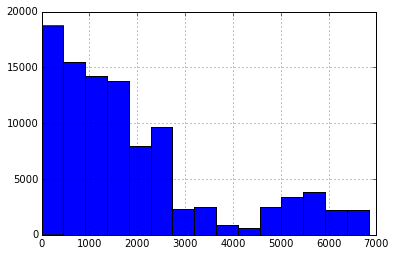

In [83]:
df['Open Date'].hist(bins =15)

In [85]:
# Days data is highly skewed, so log transform it for better performance of the models
df['Days_log'] = df['Open Date'].apply(np.log)
df = df.drop(["Open Date"], axis=1)

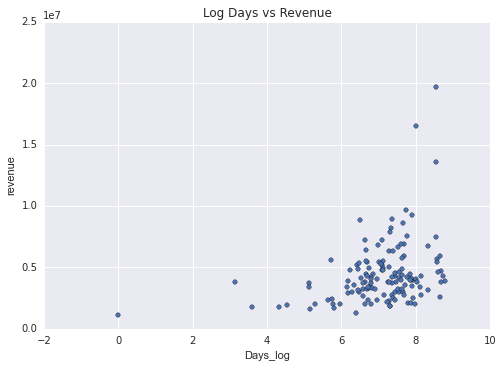

In [99]:
fig = plt.figure(figsize=(10,6))
df[['Days_log','revenue']].plot(x='Days_log', y='revenue', kind = 'scatter', title = 'Log Days vs Revenue', )

In [160]:
df[['P14', 'P15', 'P16']].apply(lambda x: min(x)==max(x), 1).sum()

51225

In [165]:
sorted(var_list.items(), key = operator.itemgetter(0))

[('Days_log', 1),
 ('P1', 0),
 ('P10', 0),
 ('P11', 0),
 ('P12', 0),
 ('P13', 0),
 ('P14', 65822),
 ('P15', 65860),
 ('P16', 66182),
 ('P17', 65880),
 ('P18', 66068),
 ('P19', 0),
 ('P2', 0),
 ('P20', 0),
 ('P21', 0),
 ('P22', 0),
 ('P23', 0),
 ('P24', 65854),
 ('P25', 65826),
 ('P26', 65872),
 ('P27', 66282),
 ('P28', 0),
 ('P29', 3085),
 ('P3', 319),
 ('P30', 65684),
 ('P31', 65654),
 ('P32', 65875),
 ('P33', 65879),
 ('P34', 65920),
 ('P35', 65864),
 ('P36', 65750),
 ('P37', 66117),
 ('P4', 0),
 ('P5', 0),
 ('P6', 0),
 ('P7', 0),
 ('P8', 0),
 ('P9', 0),
 ('revenue', 0)]

In [167]:
# by observing some columns it can be found out that there are high no of zeros in certain columns
# lets find out those cols
zeros_count = {}
cols = [col for col in df.columns if df[col].dtype!='object']
for i, col in enumerate(cols):
    zeros_count[col] = (df[col]==0).sum()

sorted(zeros_count.items(), key = operator.itemgetter(1), reverse=True)

[('P27', 66282),
 ('P16', 66182),
 ('P37', 66117),
 ('P18', 66068),
 ('P34', 65920),
 ('P17', 65880),
 ('P33', 65879),
 ('P32', 65875),
 ('P26', 65872),
 ('P35', 65864),
 ('P15', 65860),
 ('P24', 65854),
 ('P25', 65826),
 ('P14', 65822),
 ('P36', 65750),
 ('P30', 65684),
 ('P31', 65654),
 ('zeros', 7952),
 ('P29', 3085),
 ('P3', 319),
 ('Days_log', 1),
 ('P23', 0),
 ('P5', 0),
 ('P12', 0),
 ('P20', 0),
 ('P21', 0),
 ('revenue', 0),
 ('P11', 0),
 ('P28', 0),
 ('P8', 0),
 ('P10', 0),
 ('P19', 0),
 ('P6', 0),
 ('P2', 0),
 ('P7', 0),
 ('P9', 0),
 ('P1', 0),
 ('P13', 0),
 ('P4', 0),
 ('P22', 0)]

In [178]:
# The features with the notable zero behavior:
zero_cols = ['P14', 'P15', 'P16', 'P17', 'P18', 'P24', 'P25', 'P26', 'P27', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37']

# lets count the number of occurances of zeros counts across all columns

df['zeros'] = (df[zero_cols]==0).sum(1)
df[zero_cols].join(df['zeros']).head()

,P14,P15,P16,P17,P18,P24,P25,P26,P27,P30,P31,P32,P33,P34,P35,P36,P37,zeros
0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,16
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17
3,0,0,0,0,4,0,0,0,0,0,4,0,0,0,0,0,0,15
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17


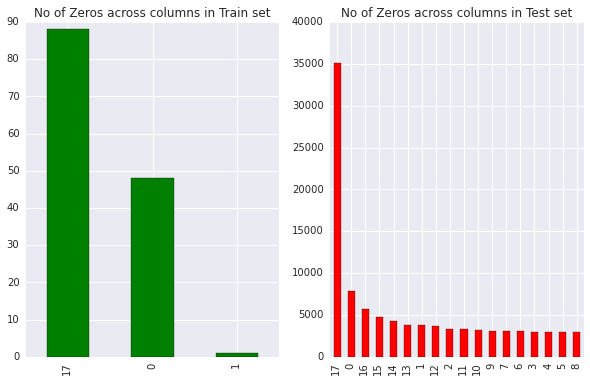

In [186]:
fig = plt.figure(figsize=(10,6))
fig.add_subplot(121)
df['zeros'].ix[pd.notnull(df.revenue)].value_counts().plot(kind='bar', title='No of Zeros across columns in Train set',color='green')

fig.add_subplot(122)

df['zeros'].ix[pd.isnull(df.revenue)].value_counts().plot(kind='bar', title='No of Zeros across columns in Test set',color='red')
# in the test set there are many rows with an intermediate count of zeros. 

plt.show()

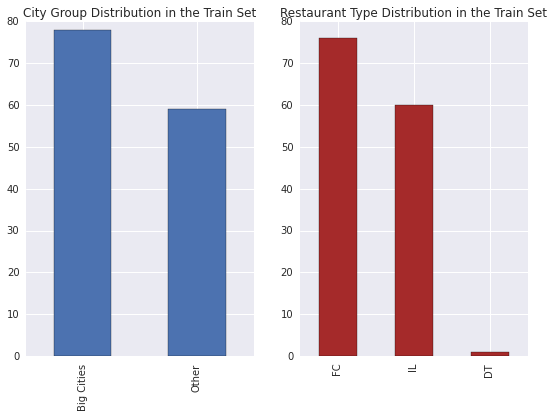

In [199]:
# lets plot City group, and Restaurant types
fig = plt.figure(figsize=(9,6))
fig.add_subplot(121)
train["City Group"].value_counts().plot(title="City Group Distribution in the Train Set", kind='bar')
fig.add_subplot(122)
train["Type"].value_counts().plot(title="Restaurant Type Distribution in the Train Set", kind='bar', color='brown')
plt.show()

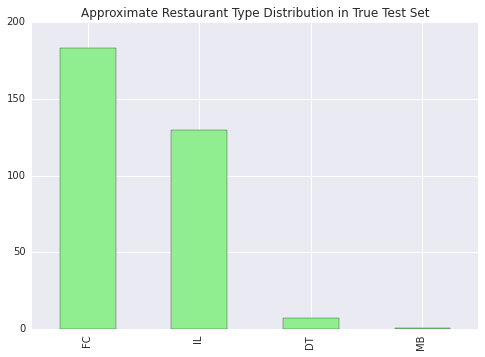

In [197]:
(test["Type"].value_counts() / FAKE_DATA_RATIO).plot(title="Approximate Restaurant Type Distribution in True Test Set", kind='bar', color='lightgreen')
plt.show()

In [200]:
# Lets convert two categorical variables, "Restaurant Type" and "City Group (Size)" 
# to dummy variables
df = df.join(pd.get_dummies(df['City Group'], prefix="CG"))
df = df.join(pd.get_dummies(df['Type'], prefix="T"))

# Since only n-1 columns are needed to binarize n categories, drop one of the new columns.  
# And drop the original columns. 
# refer http://www.algosome.com/articles/dummy-variable-trap-regression.html
# And also drop the extremely rare restaurant types (which we handleed especially below)
df = df.drop(["City Group", "Type", "CG_Other", "T_MB", "T_DT"], axis=1)

In [236]:
# Replace city names with count of their frequency in the train + estimated frequency in the test set.
#city_counts = 
city_counts = (test['City'].value_counts()/ FAKE_DATA_RATIO).add(train['City'].value_counts(), fill_value=0)
df['City'] = df['City'].replace(city_counts.to_dict().values())

# the data is skewed so take log of that 
df['City_log'] = df['City'].apply(np.log)
df = df.drop(['City'], axis=1)

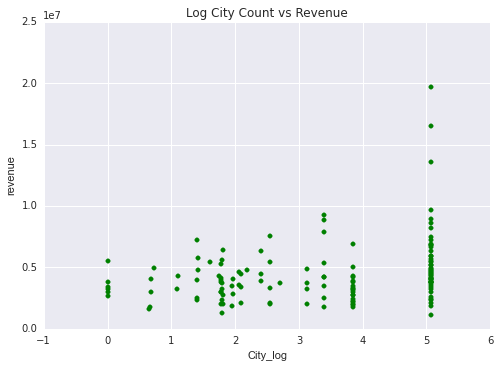

In [241]:
# That last vertical spread of points are restaurants from Istanbul.
df[["City_log", "revenue"]].plot(x="City_log", y="revenue", kind='scatter', title="Log City Count vs Revenue", color='green')
plt.show()

In [246]:
# Impute values for the very rare restaurant types. 
# Instead of trying to predict with values that appear only 1 or 0 times in the train set, 
# we will replace them with one of the other commonly appearing categories by fitting a 
# model that predicts which common category they "should" be.

# tofit are the rows in the train set that belong to one of the common restaurnat types

tofit = df.ix[((df.T_FC==1) | (df.T_IL==1)) & (pd.notnull(df.revenue))]

# tofill are rows in either train or test that belong to one of the rare types
tofill = df.ix[((df.T_FC==0) & (df.T_IL==0))]



In [251]:
# Resaruants with type FC are labeled 1, those with type IL are labeled 0.
y = tofit.T_FC
# Drop the label columns and revenue (which is not in the test set, so can't be used here)
X = tofit.drop(["T_FC", "T_IL", "revenue"], axis=1)

In [257]:
# Define and train a model to impute restaurant type
# The grid below just has a range of values that I've found commonly
# work well with random forest type models (of which ExtraTrees is one)

model_grid = {'max_depth': [None, 8], 'min_samples_split': [4,9,16], 'min_samples_leaf':[1,4], 'max_features':['sqrt', 0.5, None]}
type_model = ExtraTreesClassifier(n_estimators=25, random_state=SEED)

grid = RandomizedSearchCV(type_model, model_grid, n_iter=10, cv=5, scoring="roc_auc")
grid.fit(X, y)
print("Best parameters for Type Model:")
print(grid.best_params_)

Best parameters for Type Model:
{'min_samples_split': 16, 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1}


In [259]:
type_model.set_params(**grid.best_params_)
type_model.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.5, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [262]:
imputations = type_model.predict(tofill.drop(["T_FC", "T_IL", "revenue"], axis=1))
df.loc[(df.T_FC==0) & (df.T_IL==0), "T_FC"] = imputations
df = df.drop(["T_IL"], axis=1)

In [264]:
# Now binarize the "P" columns with dummy variables
print("Pre-binarizing columns:", len(df.columns))
for col in df.columns:
    if col[0] == 'P':
        print(col, len(df[col].unique()), "unique values")
        df = df.join(pd.get_dummies(df[col], prefix=col))
        df = df.drop([col, df.columns[-1]], axis=1)
print("Post-binarizing columns:", len(df.columns))

Pre-binarizing columns: 43
P1 9 unique values
P10 4 unique values
P11 8 unique values
P12 7 unique values
P13 5 unique values
P14 10 unique values
P15 9 unique values
P16 10 unique values
P17 10 unique values
P18 9 unique values
P19 9 unique values
P2 9 unique values
P20 9 unique values
P21 9 unique values
P22 5 unique values
P23 9 unique values
P24 9 unique values
P25 9 unique values
P26 10 unique values
P27 10 unique values
P28 9 unique values
P29 8 unique values
P3 8 unique values
P30 10 unique values
P31 10 unique values
P32 10 unique values
P33 7 unique values
P34 11 unique values
P35 8 unique values
P36 10 unique values
P37 8 unique values
P4 7 unique values
P5 7 unique values
P6 8 unique values
P7 7 unique values
P8 8 unique values
P9 5 unique values
Post-binarizing columns: 279


In [265]:
# Scale all input features to between 0 and 1, critical to do this for KNN or SVR models.
min_max_scaler = MinMaxScaler()
# Don't scale the output - drop it temporarily
rev = df.revenue
df = df.drop(['revenue'], axis=1)

df = pd.DataFrame(data = min_max_scaler.fit_transform(df), columns = df.columns, index=df.index)
df = df.join(rev)

# Done with preprocessing. Let's take a last look at the data before modeling with it.
df.describe()

,Days_log,zeros,CG_Big Cities,T_FC,City_log,P1_1,P1_2,P1_3,P1_4,P1_5,...,P8_3,P8_4,P8_5,P8_6,P8_8,P9_4,P9_5,P9_6,P9_8,revenue
count,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,...,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,137.000000
mean,0.803995,0.658151,0.492825,0.587206,0.632233,0.051989,0.224752,0.228447,0.282912,0.068566,...,0.061745,0.381507,0.393970,0.015888,0.065620,0.351429,0.499396,0.003066,0.065271,4453532.613139
std,0.124607,0.360692,0.499951,0.492339,0.320736,0.222005,0.417421,0.419834,0.450416,0.252716,...,0.240694,0.485759,0.488631,0.125044,0.247618,0.477419,0.500002,0.055285,0.247004,2576071.595708
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1149870.000000
25%,0.735570,0.352941,0.000000,0.000000,0.394308,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2999068.000000
50%,0.822789,0.764706,0.000000,1.000000,0.623604,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3939804.000000
75%,0.886367,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,5166635.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19696939.000000


In [267]:
# Recover original train/train rows based on revenue (which is null for test rows)
train = df.ix[pd.notnull(df.revenue)]
test = df.ix[pd.isnull(df.revenue)].drop(['revenue'], axis=1)

# Scale revenue by sqrt. 
# The purpose is to decrease the influence of the few very large revenue values.
y = train['revenue'].apply(np.sqrt)
X = train.drop(["revenue"], axis=1)

In [269]:
# Now define and train a Ridge Regression model. We tested others from the sklearn package:
# SVR, RandomForest, K-nearest Neighbors, but found Ridge consistantly gave the strongest 
# leaderboard results. When training data is small, simplest is often best.
model_grid = [{'normalize': [True, False], 'alpha': np.logspace(0,10)}]
model = Ridge()

# Use a grid search and leave-one-out CV on the train set to find the best regularization parameter to use.
# (might take a minute or two)
grid = GridSearchCV(model, model_grid, cv=LeaveOneOut(len(y)), scoring='mean_squared_error')
grid.fit(X, y)
print("Best parameters set found on development set:")
print(grid.best_params_)


Best parameters set found on development set:
{'alpha': 4.0949150623804256, 'normalize': True}


In [270]:
# Re-train on full training set using the best parameters found in the last step.
model.set_params(**grid.best_params_)
model.fit(X, y)

Ridge(alpha=4.0949150623804256, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, solver='auto', tol=0.001)

In [279]:
sorted(zip(abs(model.coef_), X.columns))

[(0.0, 'P15_6'),
 (0.0, 'P16_6'),
 (0.0, 'P17_12'),
 (0.0, 'P18_2'),
 (0.0, 'P21_12'),
 (0.0, 'P25_6'),
 (0.0, 'P27_7.5'),
 (0.0, 'P2_1.5'),
 (0.0, 'P30_2'),
 (0.0, 'P33_1'),
 (0.0, 'P34_1'),
 (0.0, 'P34_6'),
 (0.0, 'P36_1'),
 (0.0, 'P36_8'),
 (0.0, 'P4_2.0'),
 (0.0, 'P7_6'),
 (0.0, 'P9_6'),
 (0.03724835145967826, 'P23_20'),
 (0.45063184412658924, 'P15_8'),
 (0.49843272854484755, 'P4_4.0'),
 (0.80966382585768315, 'P27_0.0'),
 (0.82950450700610123, 'P14_0'),
 (0.82950450700610123, 'P15_0'),
 (0.82950450700610123, 'P16_0'),
 (0.82950450700610123, 'P17_0'),
 (0.82950450700610123, 'P18_0'),
 (0.82950450700610123, 'P24_0'),
 (0.82950450700610123, 'P25_0'),
 (0.82950450700610123, 'P26_0.0'),
 (0.82950450700610123, 'P30_0'),
 (0.82950450700610123, 'P31_0'),
 (0.82950450700610123, 'P32_0'),
 (0.82950450700610123, 'P33_0'),
 (0.82950450700610123, 'P34_0'),
 (0.82950450700610123, 'P35_0'),
 (0.82950450700610123, 'P36_0'),
 (0.82950450700610123, 'P37_0'),
 (0.82979734756383805, 'zeros'),
 (0.8488

In [271]:
# Predict on the test set with the trained model.
submission = pd.DataFrame(columns=['Prediction'],index=test.index, data=model.predict(test))
# Convert back to revenue from sqrt(revenue)
submission['Prediction'] = submission['Prediction'].apply(np.square)
# Add required column name for Kaggle's submission parser:
submission.index.name='Id'
# Write out the submission
submission.to_csv("/Users/Sri/Desktop/Kaggle/TFI Restaurant Sales/TFI_Ridge.csv")


In [272]:
# Quick sanity check on the submission
submission.describe().astype(int)

,Prediction
count,100000
mean,4306049
std,644223
min,2180202
25%,3880507
50%,4246704
75%,4652960
max,8874955


In [273]:
# Revenue from train set for comparison
train[['revenue']].describe().astype(int)

,revenue
count,137
mean,4453532
std,2576071
min,1149870
25%,2999068
50%,3939804
75%,5166635
max,19696939


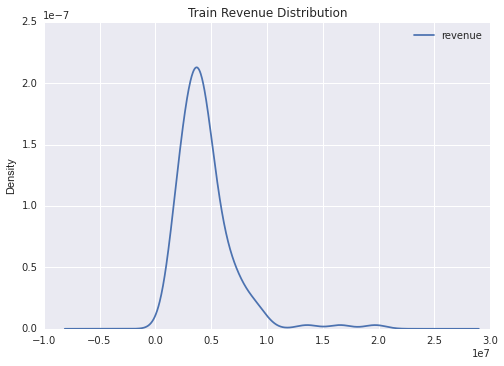

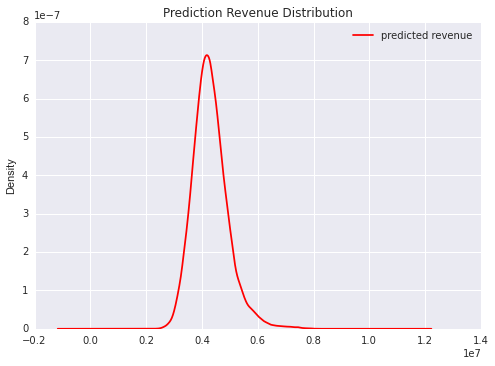

In [275]:
# Another quick comparision. Note the x-axis scale change: the predictions are 
# more conservative and tend to be closer to the mean than the real revenues. 
# This is pretty standard behavior when using RMSE - there are big penalties for 
# being very wrong, so the model will tend towards more moderate predictions.
train[['revenue']].plot(kind='kde', title="Train Revenue Distribution")
submission.columns = ["predicted revenue"]
submission.plot(kind='kde', title="Prediction Revenue Distribution", color='r')
plt.show()